# Load data

In [1]:
import numpy as np
import pandas as pd
import anndata
import os

In [2]:
import torch
import pickle
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "/bigstore/GeneralStorage/fangming/projects/visctx/propose")
from propose import PROPOSE, HurdleLoss, ExpressionDataset
from propose import models, Accuracy

from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import *

In [3]:
ddir = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/counts/'
resdir = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/test_propose'

In [4]:
!ls $resdir

classification_metric.pkl
classification_metric_v2.pkl
eval_L234_allgenes_sep13.pkl
eval_L234_allgenes_sep14.pkl
eval_merfish_L234_allgenes_oct6.pkl
eval_merfish_L234_allgenes_unsupervised_oct13.pkl
eval_merfish_P14_NR_L234_oct28.pkl
eval_merfish_P28_oct24.pkl
fig_L234_allgenes_sep13.pdf
fig_L234_allgenes_sep14.pdf
fig_merfish_L234_allgenes_oct6.pdf
propose_class_results.pkl
propose_class_results_v2.pkl
res_L234_allgenes_sep13.pkl
res_L234_allgenes_sep14.pkl
res_merfish_L234_allgenes_oct6.pkl
res_merfish_L234_allgenes_unsupervised_oct13.pkl
res_merfish_P14_NR_L234_oct28.pkl
res_merfish_P28_oct24.pkl


# Plot eval

In [5]:
# Plot results
with open(os.path.join(resdir, 'eval_merfish_P14_NR_L234_oct28.pkl'), 'rb') as f:
    results = pickle.load(f)
num_features = list(results['PROPOSE-Class'].keys())

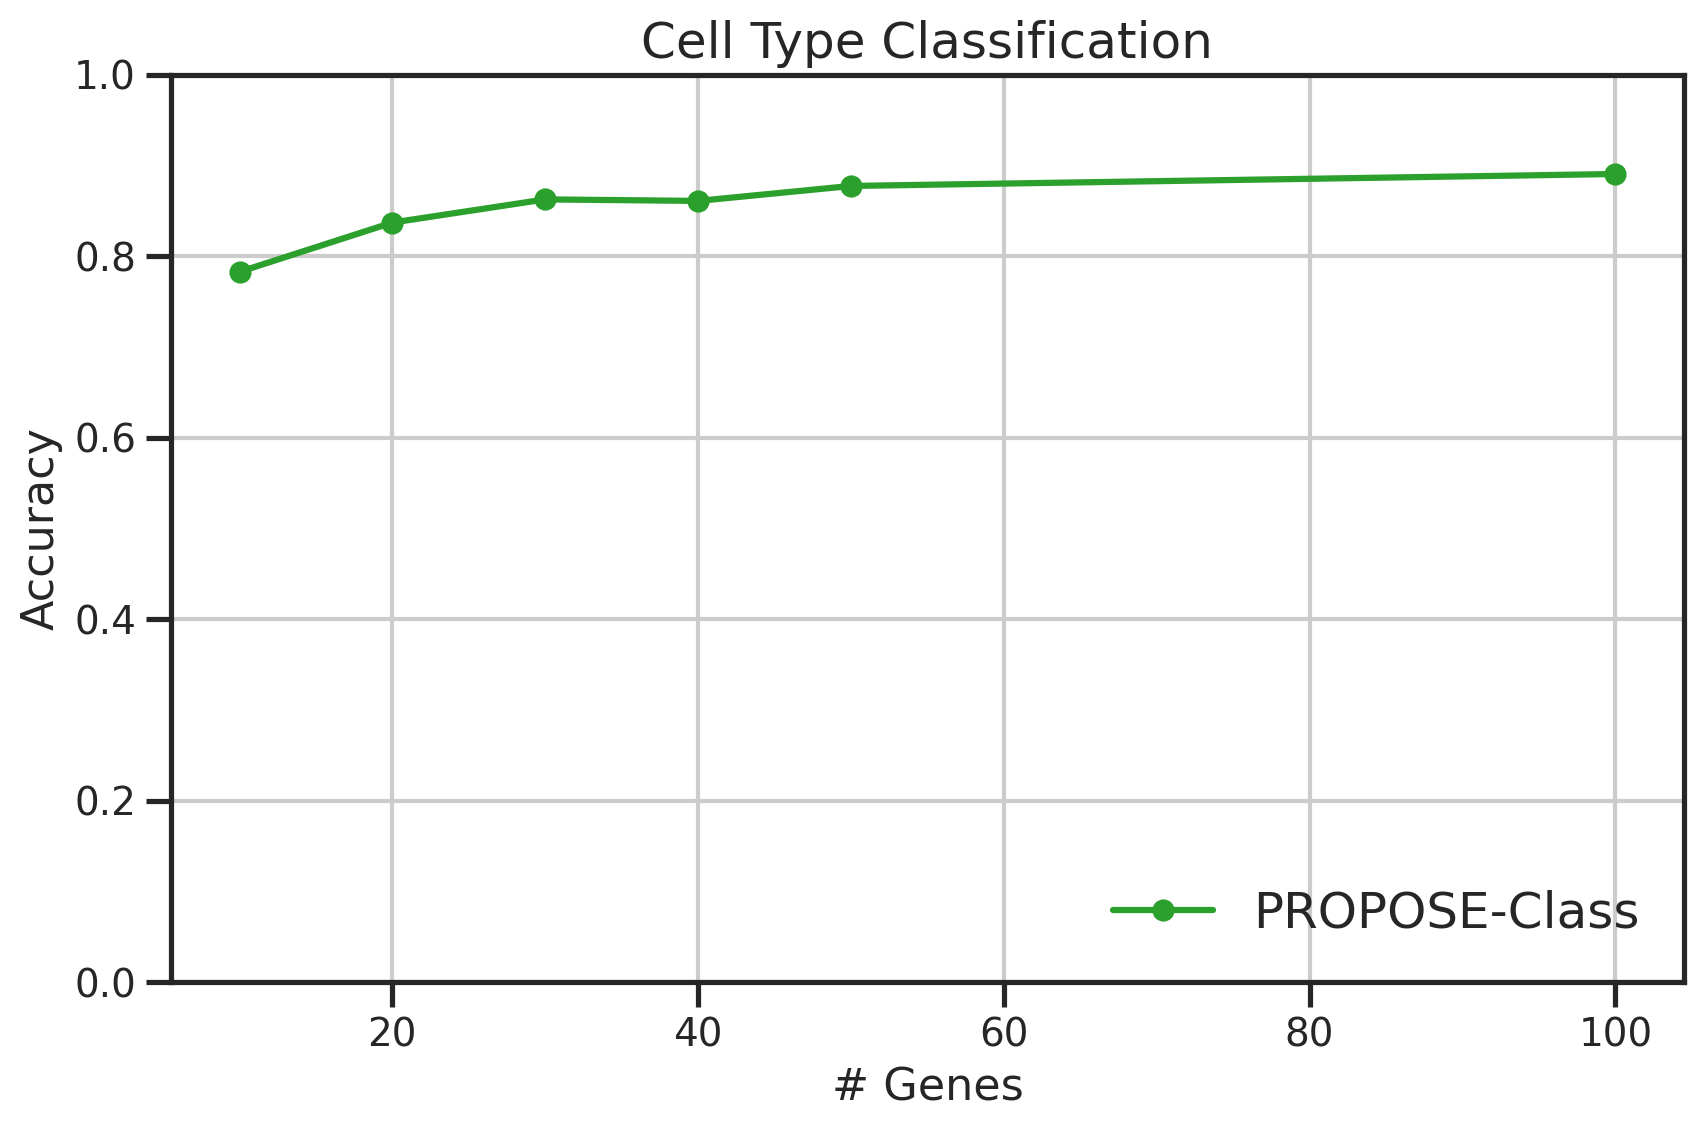

In [6]:
# Make plot
plt.figure(figsize=(9, 6))
plt.plot(num_features, [results['PROPOSE-Class'][num] for num in num_features],
         marker='o', markersize=7, color='C2', label='PROPOSE-Class')
plt.legend(loc='lower right', fontsize=18, frameon=False)
plt.tick_params(labelsize=14)
plt.title('Cell Type Classification', fontsize=18)
plt.xlabel('# Genes', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
plt.ylim([0,1])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


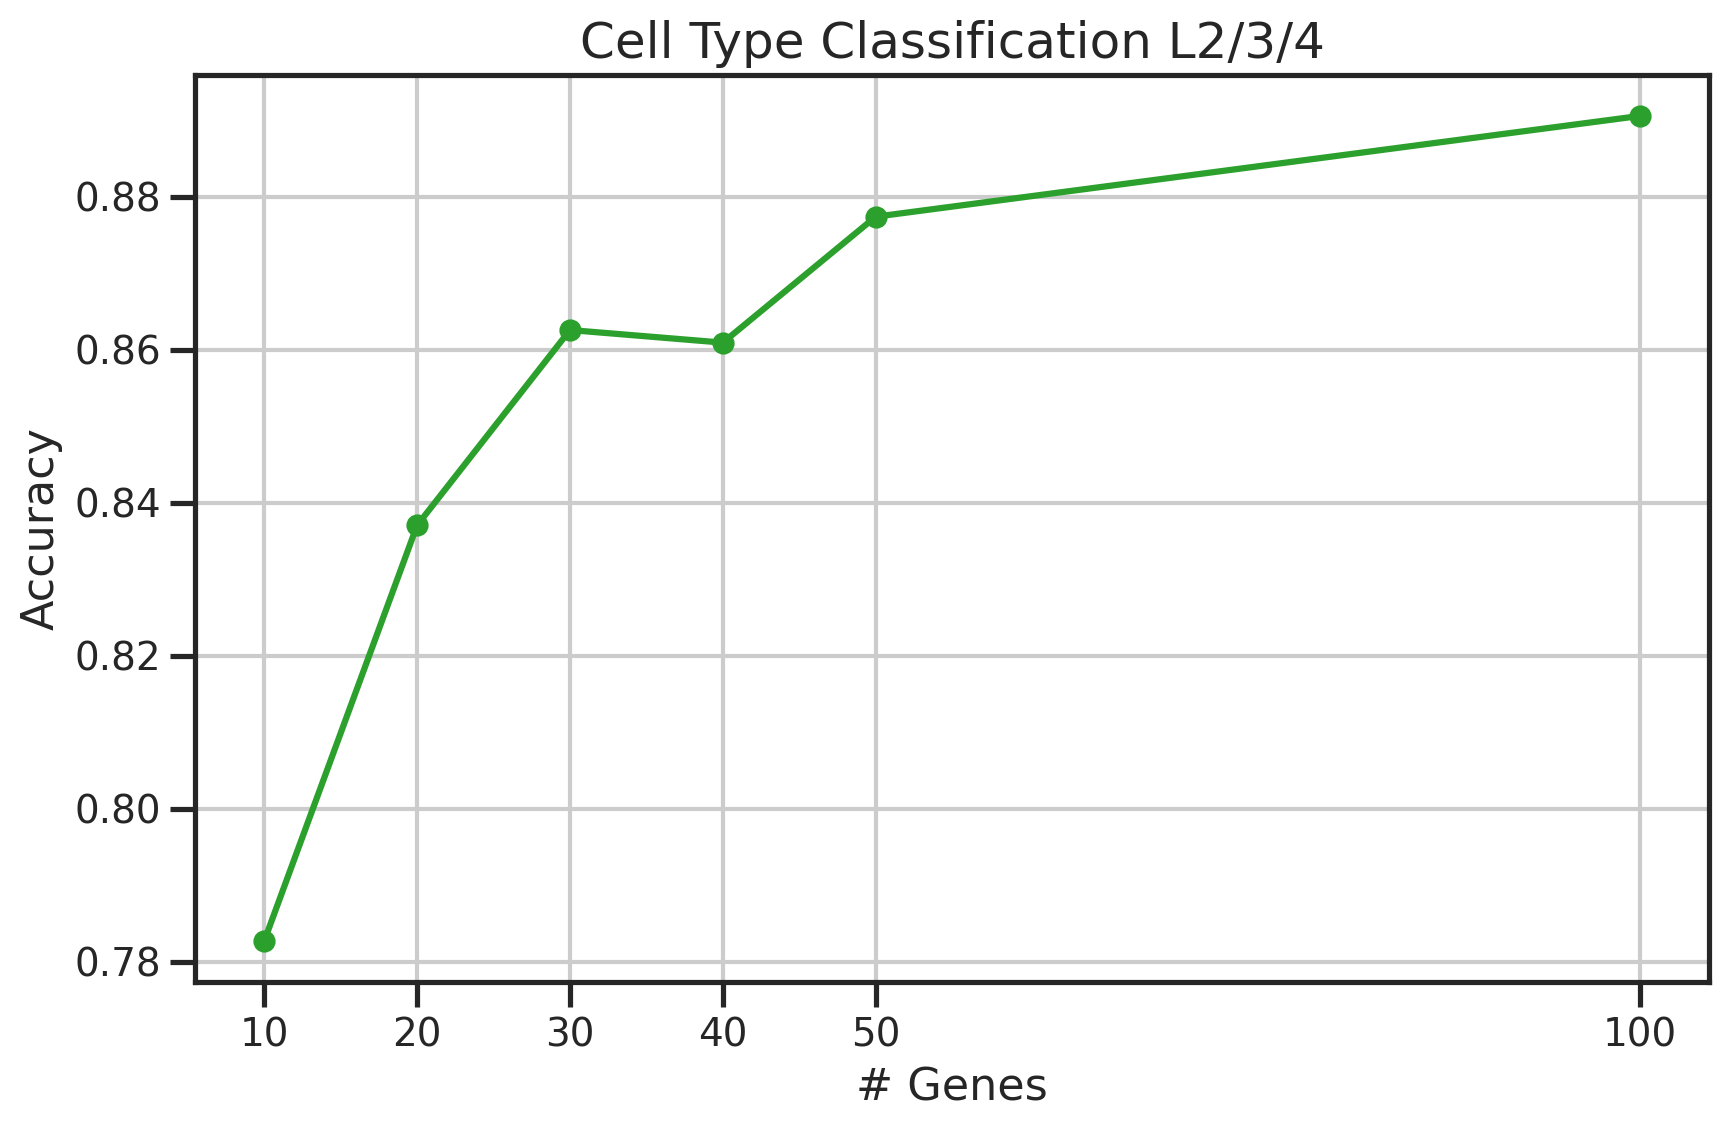

In [7]:
# Make plot
plt.figure(figsize=(9, 6))
plt.plot(num_features, [results['PROPOSE-Class'][num] for num in num_features],
         marker='o', markersize=7, color='C2',)
plt.legend(loc='lower right', fontsize=18, frameon=False)
plt.tick_params(labelsize=14)
plt.title('Cell Type Classification L2/3/4', fontsize=18)
plt.xlabel('# Genes', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
# plt.ylim([0,1])
plt.xticks(num_features)
plt.show()

In [8]:
results

{'PROPOSE-Class': {10: 0.7827160358428955,
  20: 0.8370370268821716,
  30: 0.8625514507293701,
  40: 0.8609053492546082,
  50: 0.8773662447929382,
  100: 0.8905349969863892}}

# get gene names

In [9]:
# which genes
with open(os.path.join(resdir, 'res_merfish_P14_NR_L234_oct28.pkl'), 'rb') as f:
    res = pickle.load(f)
# res
for key in res.keys():
    print(key, np.unique(res[key]).shape)

10 (10,)
20 (20,)
30 (30,)
40 (40,)
50 (50,)
100 (100,)


# vis data
# get heatmap

In [10]:
def rename_clsts(x):
    thedict = {
        'L2/3_A': 'L2/3_B',
        'L2/3_B': 'L2/3_A',
    }
    if x in thedict.keys():
        return thedict[x]
    else:
        return x

In [11]:
f = '/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/counts/P14_nr_L234_Oct26.h5ad' 
adata = anndata.read(f)
print(adata.shape)
gene_names = adata.var.index.values
adata.obs['Type'] = adata.obs['Type'].apply(rename_clsts)  # do we do this?
np.array(gene_names[res[10]])

(12157, 53547)


/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


array(['Tox', 'Nell1', 'Hs3st4', 'Tcerg1l', 'Gm15398', 'Klhl1',
       'BC006965', 'Iqgap2', 'Mdga1', 'L3mbtl4'], dtype=object)

In [12]:
allgenes = []
for key in res.keys():
    allgenes = np.union1d(allgenes, res[key])
    print(key, res[key].shape, allgenes.shape)
    
allgenes = allgenes.astype(int)
adatasub = adata[:, gene_names[allgenes.astype(int)]]
adatasub

10 (10,) (10,)
20 (20,) (21,)
30 (30,) (40,)
40 (40,) (61,)
50 (50,) (79,)
100 (100,) (124,)


View of AnnData object with n_obs × n_vars = 12157 × 124
    obs: 'cov', 'covfactor', 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'Class_broad', 'sample', 'Type', 'Subclass'
    var: 'id'

In [13]:
%%time

# coverage
cellcov = np.asarray(adata.X.sum(axis=1)).reshape(-1,)
# relevant counts
mat = np.asarray(adatasub.X.todense())

# pseudo-bulk samples -- pull counts from cells
Xk, xclsts = basicu.group_sum(mat, adata.obs['Type'])
ck, xclsts = basicu.group_sum(cellcov.reshape(-1,1), adata.obs['Type'])
Xk = np.log10(1+(np.array(Xk)/np.array(ck))*1e6) # log10(1+CPM)

Xk = pd.DataFrame(Xk, index=xclsts, columns=gene_names[allgenes])
Xk = basicu.zscore(Xk, axis=0)
Xk.shape, xclsts.shape, xclsts

CPU times: user 237 ms, sys: 5.32 ms, total: 243 ms
Wall time: 239 ms


((5, 124),
 (5,),
 array(['L2/3_AB', 'L2/3_BC', 'L4_A', 'L4_B', 'L4_C'], dtype=object))

In [14]:
types_order = [
    'L2/3_AB', 'L2/3_BC',  
    'L4_A', 'L4_B', 'L4_C', 
]

In [15]:
Xk = Xk.loc[types_order]

In [16]:
def plot_num(Xk, num, cbar=True):
    X_s = Xk[gene_names[res[num]]].T
    g = sns.clustermap(X_s,
                    col_cluster=False,
                    yticklabels=True,
                    cmap='coolwarm',
                    center=0,
                    dendrogram_ratio=0.15,
                    vmax=2, vmin=-2,
                    figsize=(7, min(15, num*0.3)), 
                    cbar_kws=dict(label='zscore'),
                    cbar=cbar,
                   )
    g.ax_row_dendrogram.set_visible(False)
    g.ax_heatmap.vlines([6, 16, 20, 25, 28, 31, 33, 38, 39], ymin=0, ymax=num, color='white', linewidth=1)
    g.ax_heatmap.set_title(f"PROPOSE genes supervised\n(n={len(X_s)})")

    if not cbar:
        g.ax_cbar.axis('off')
    plt.show()

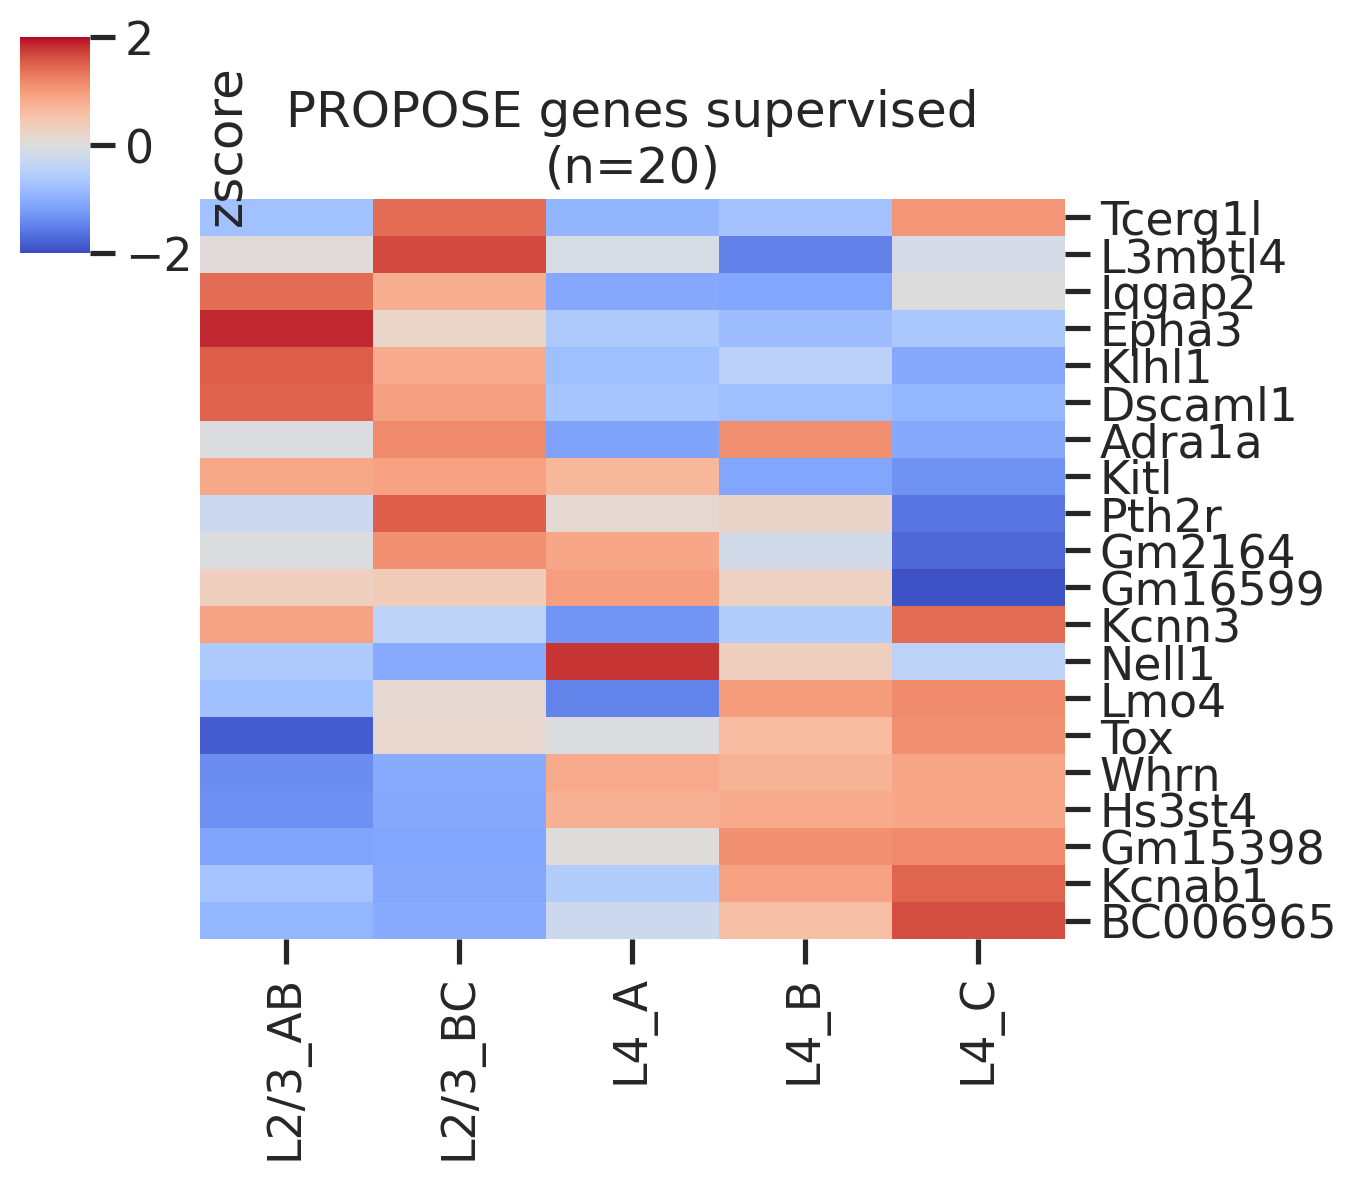

In [17]:
plot_num(Xk, 20)

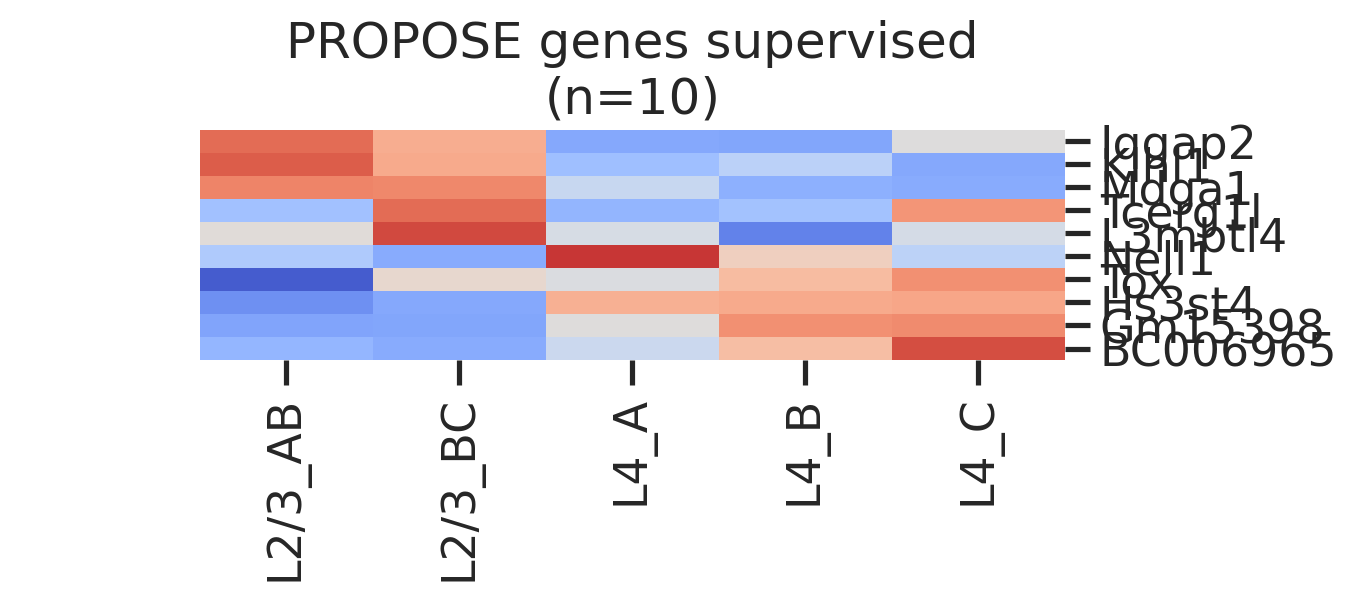

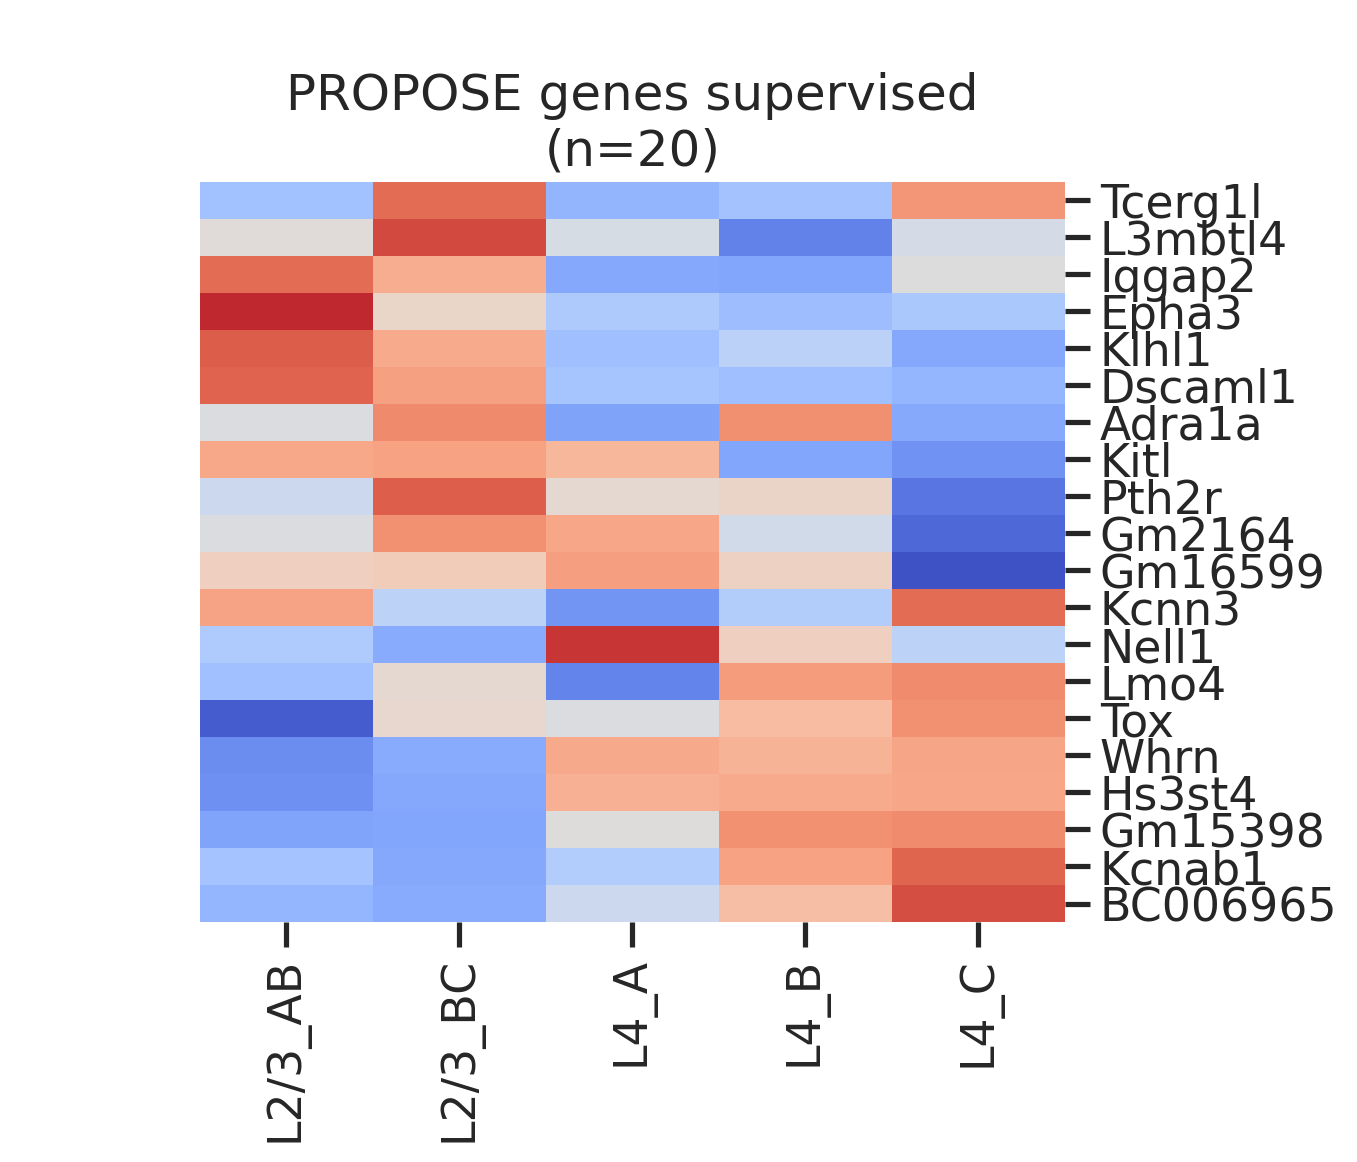

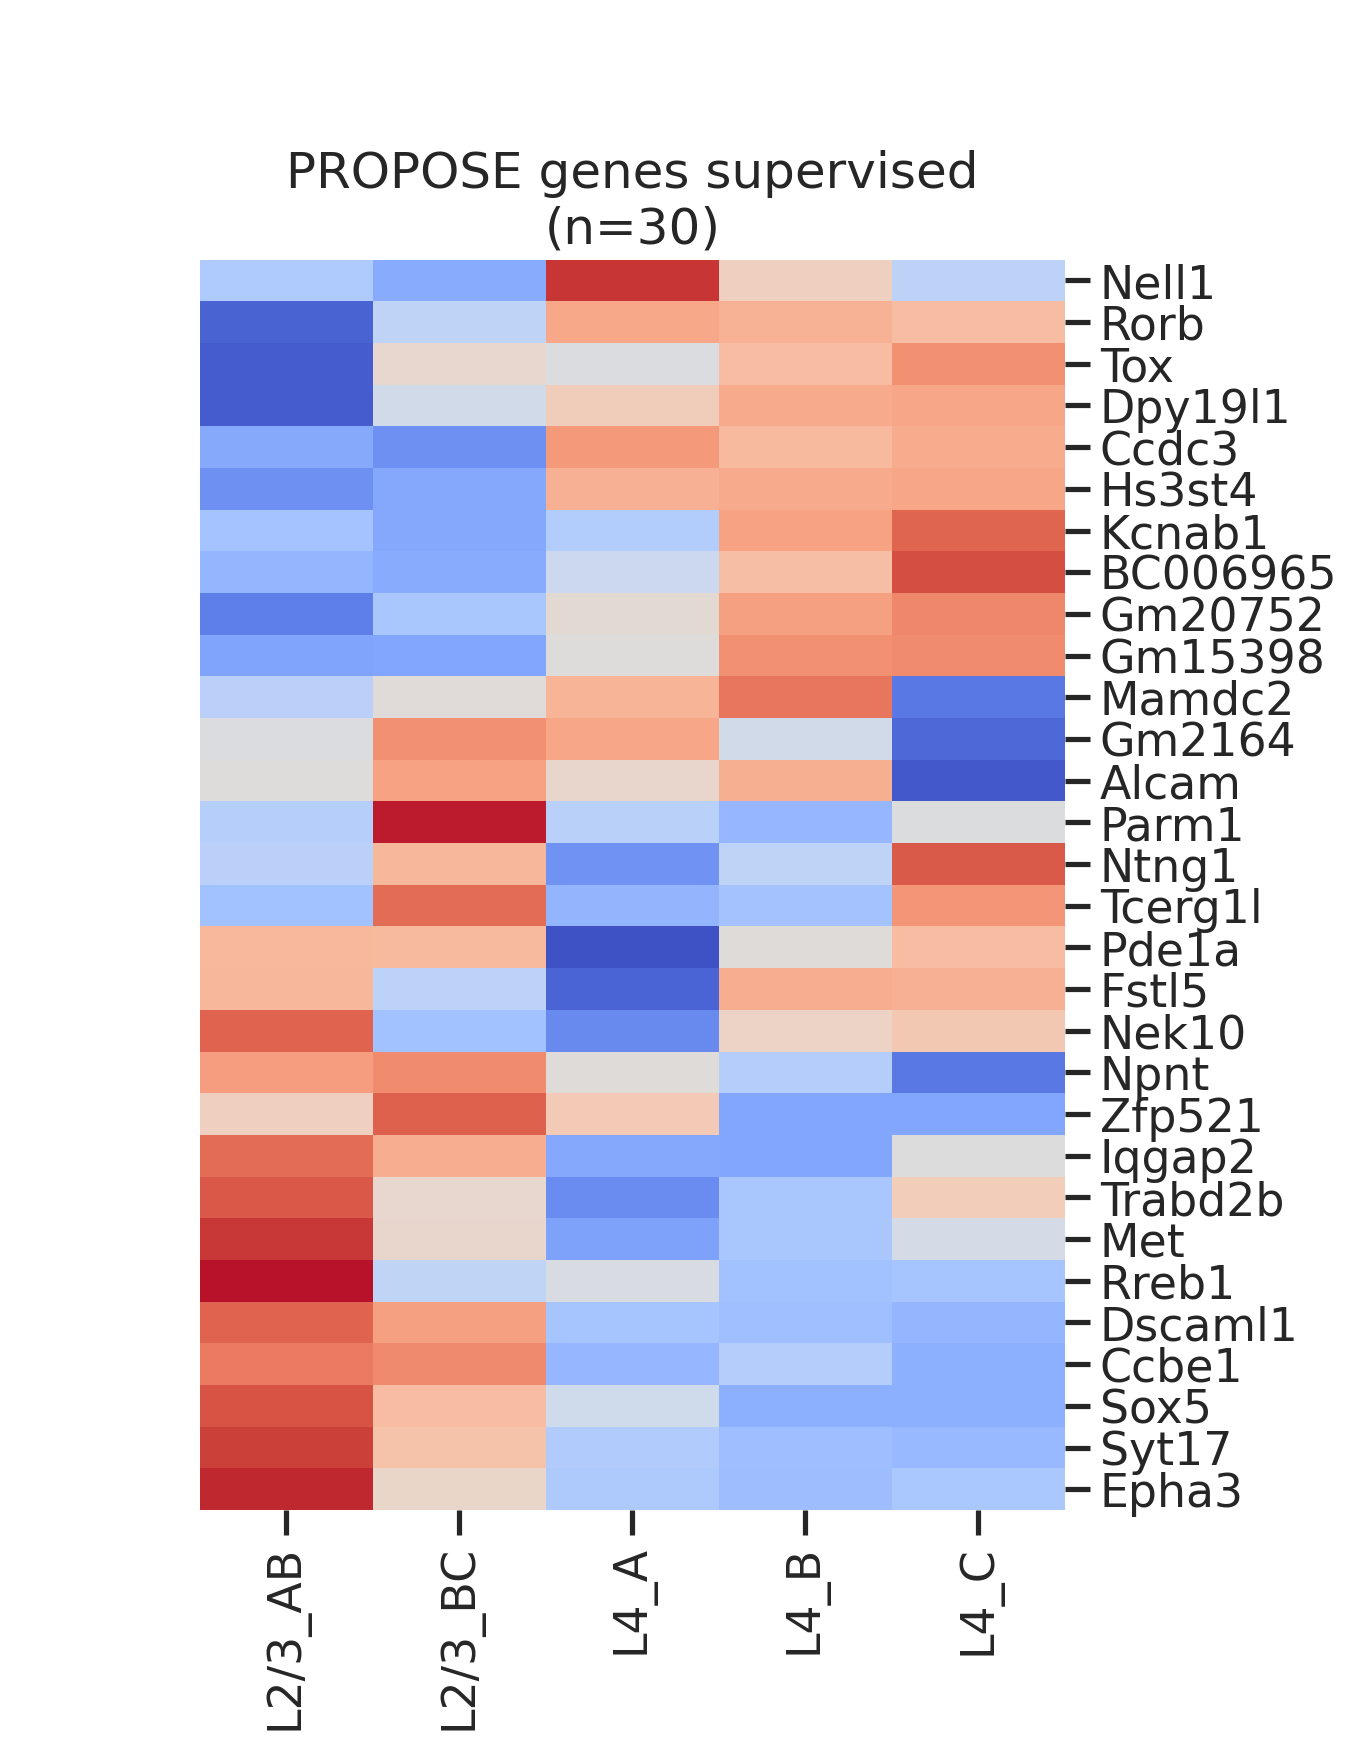

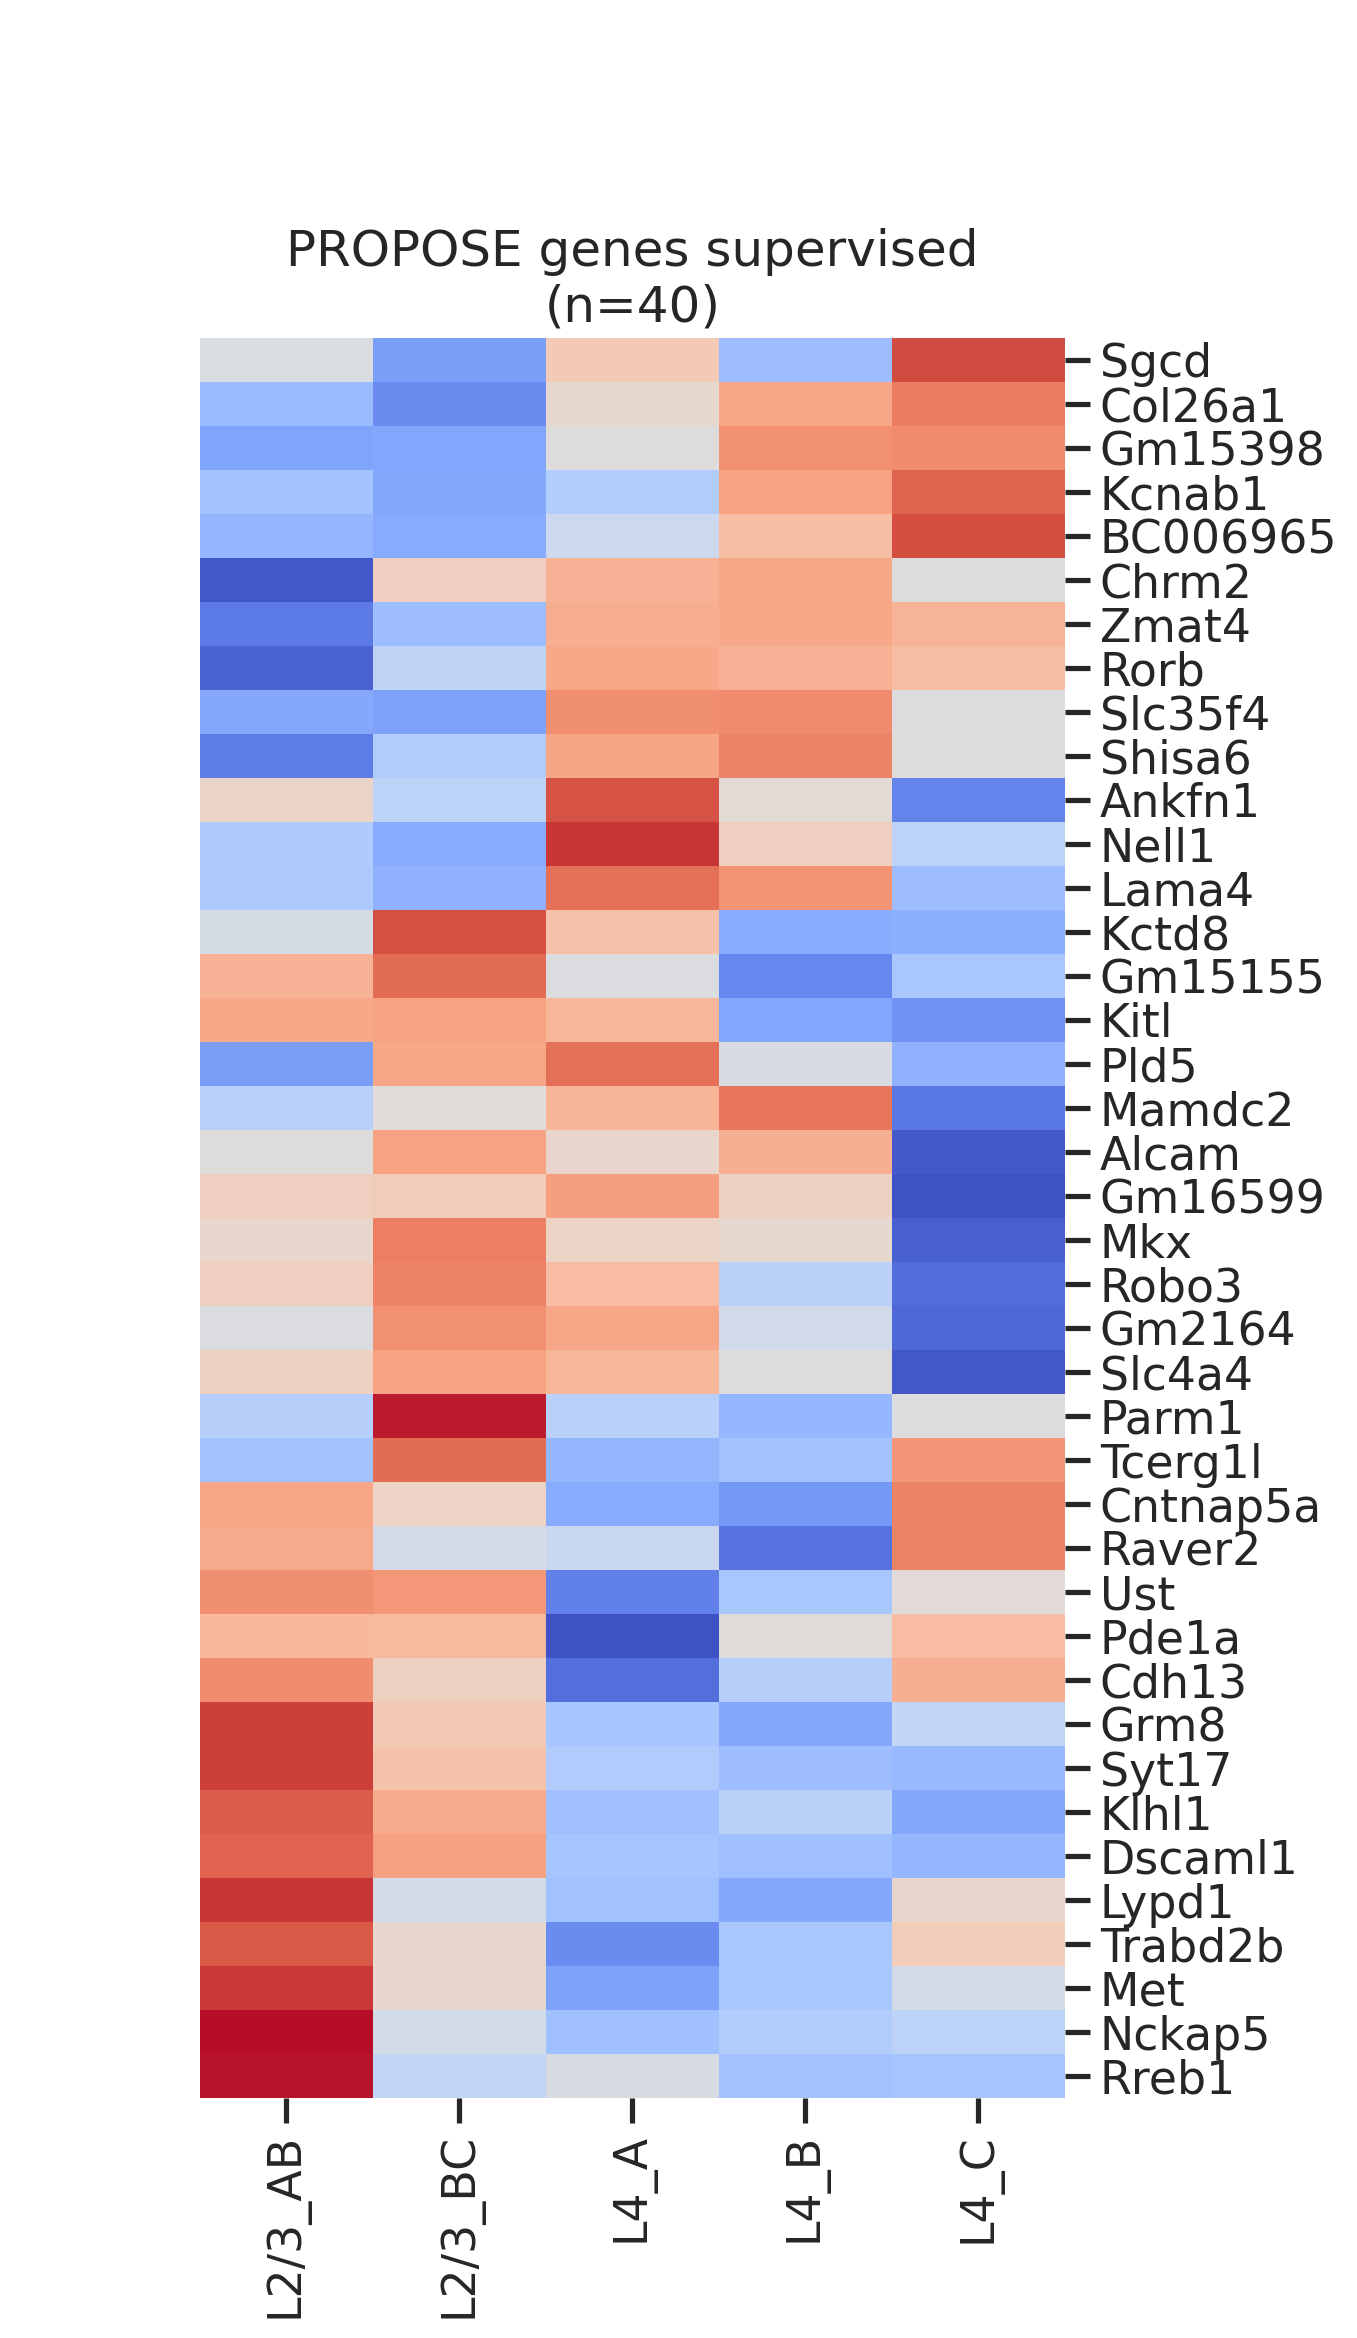

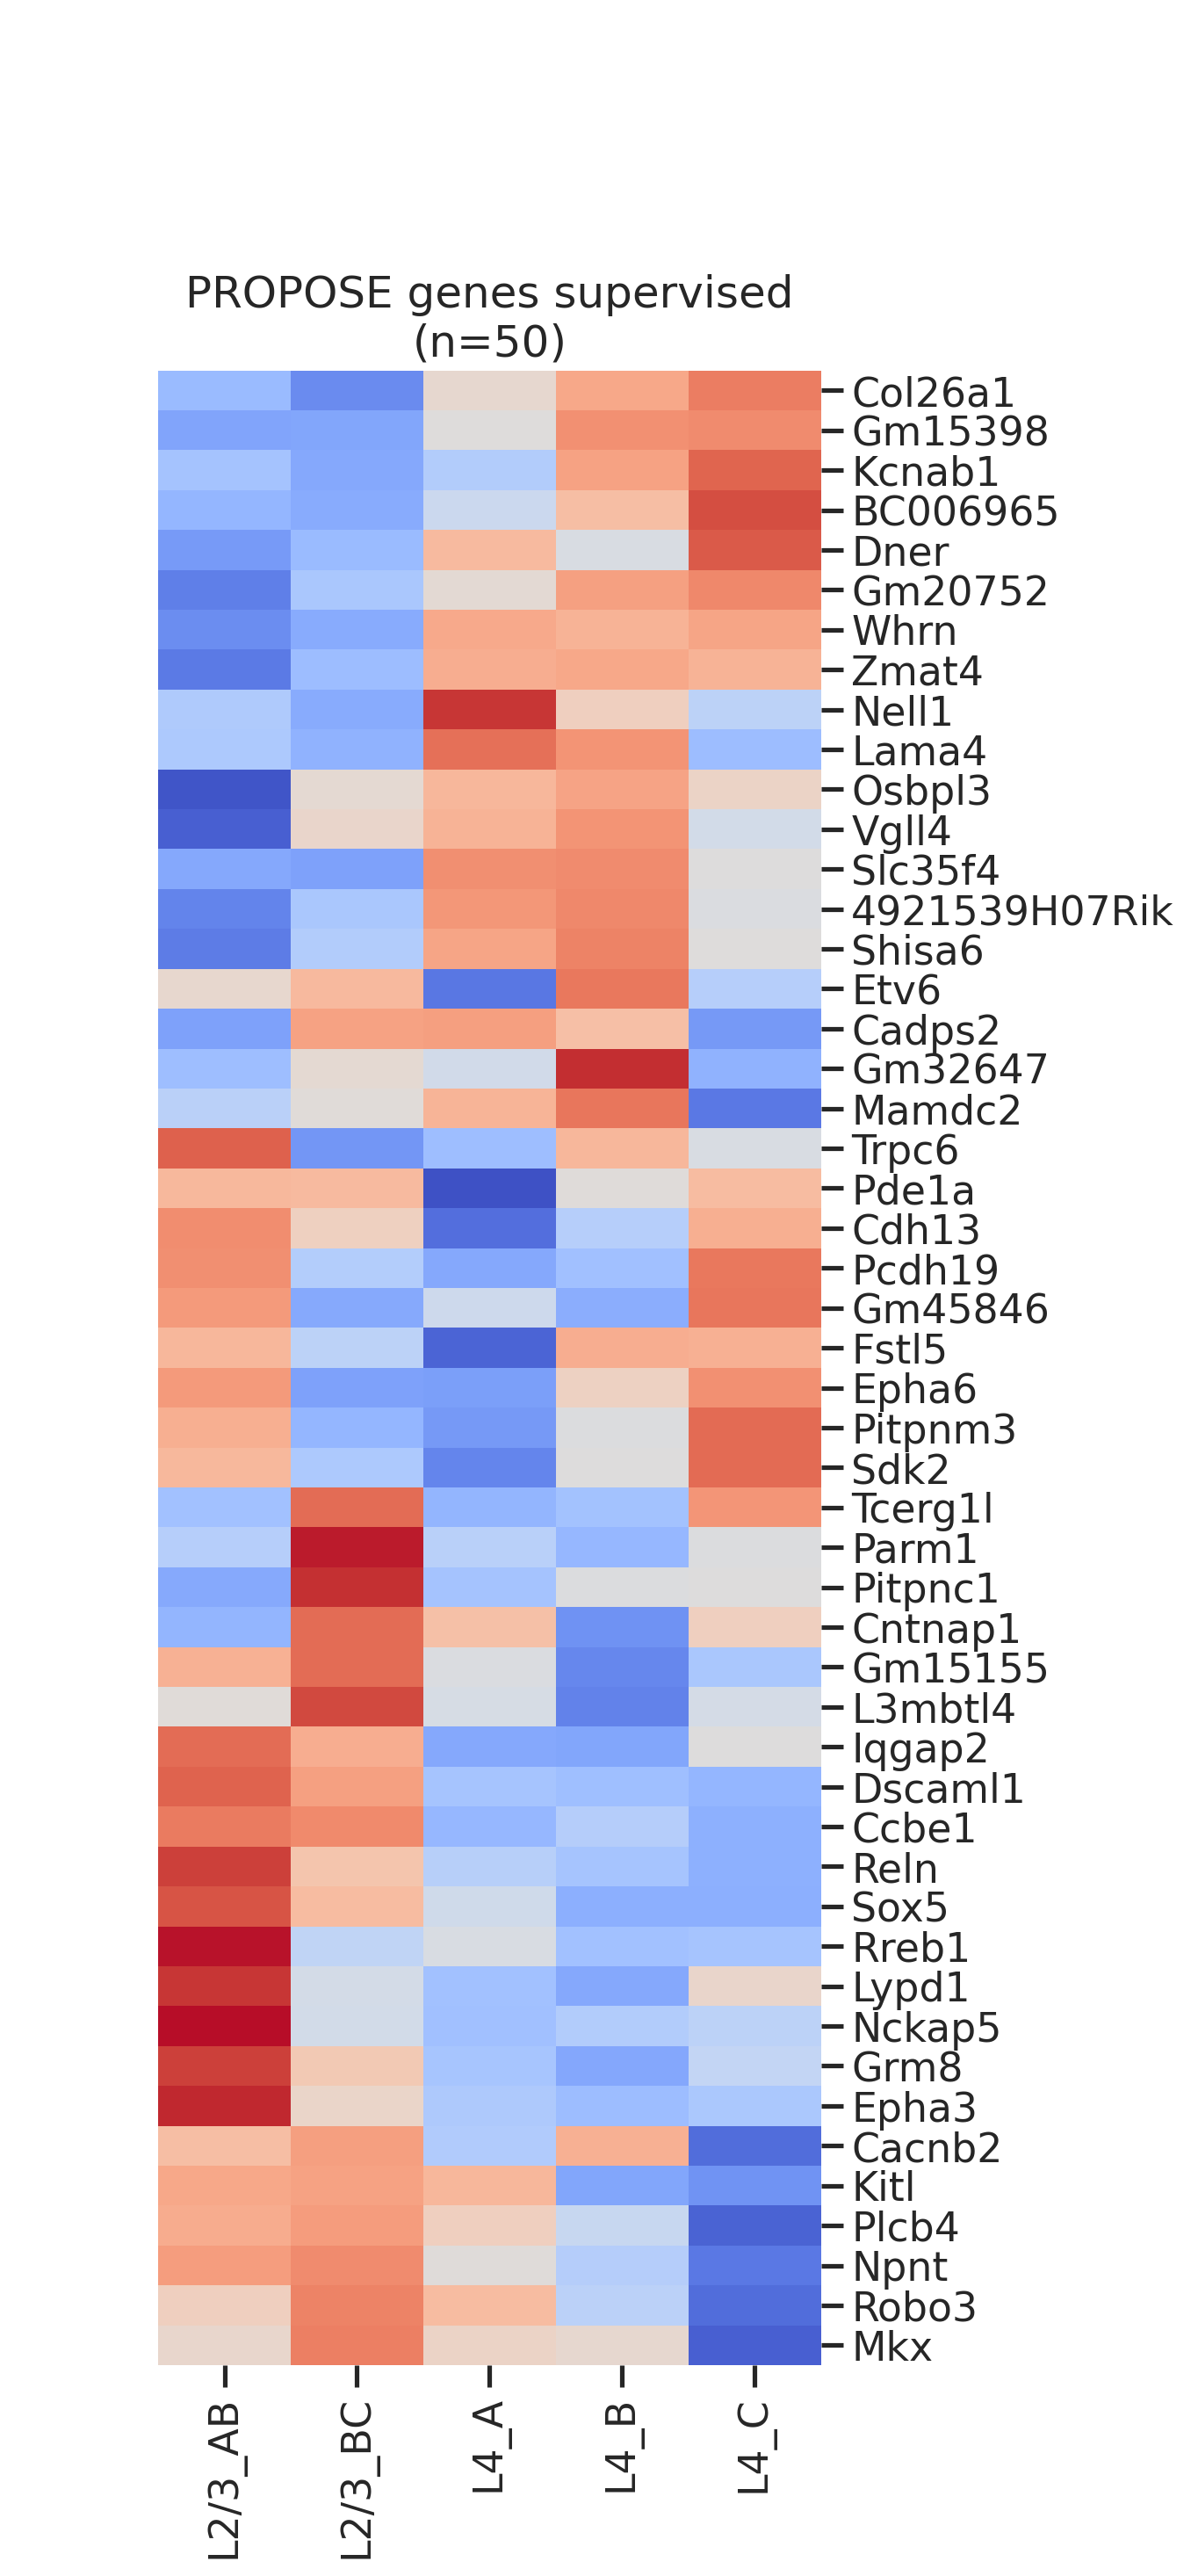

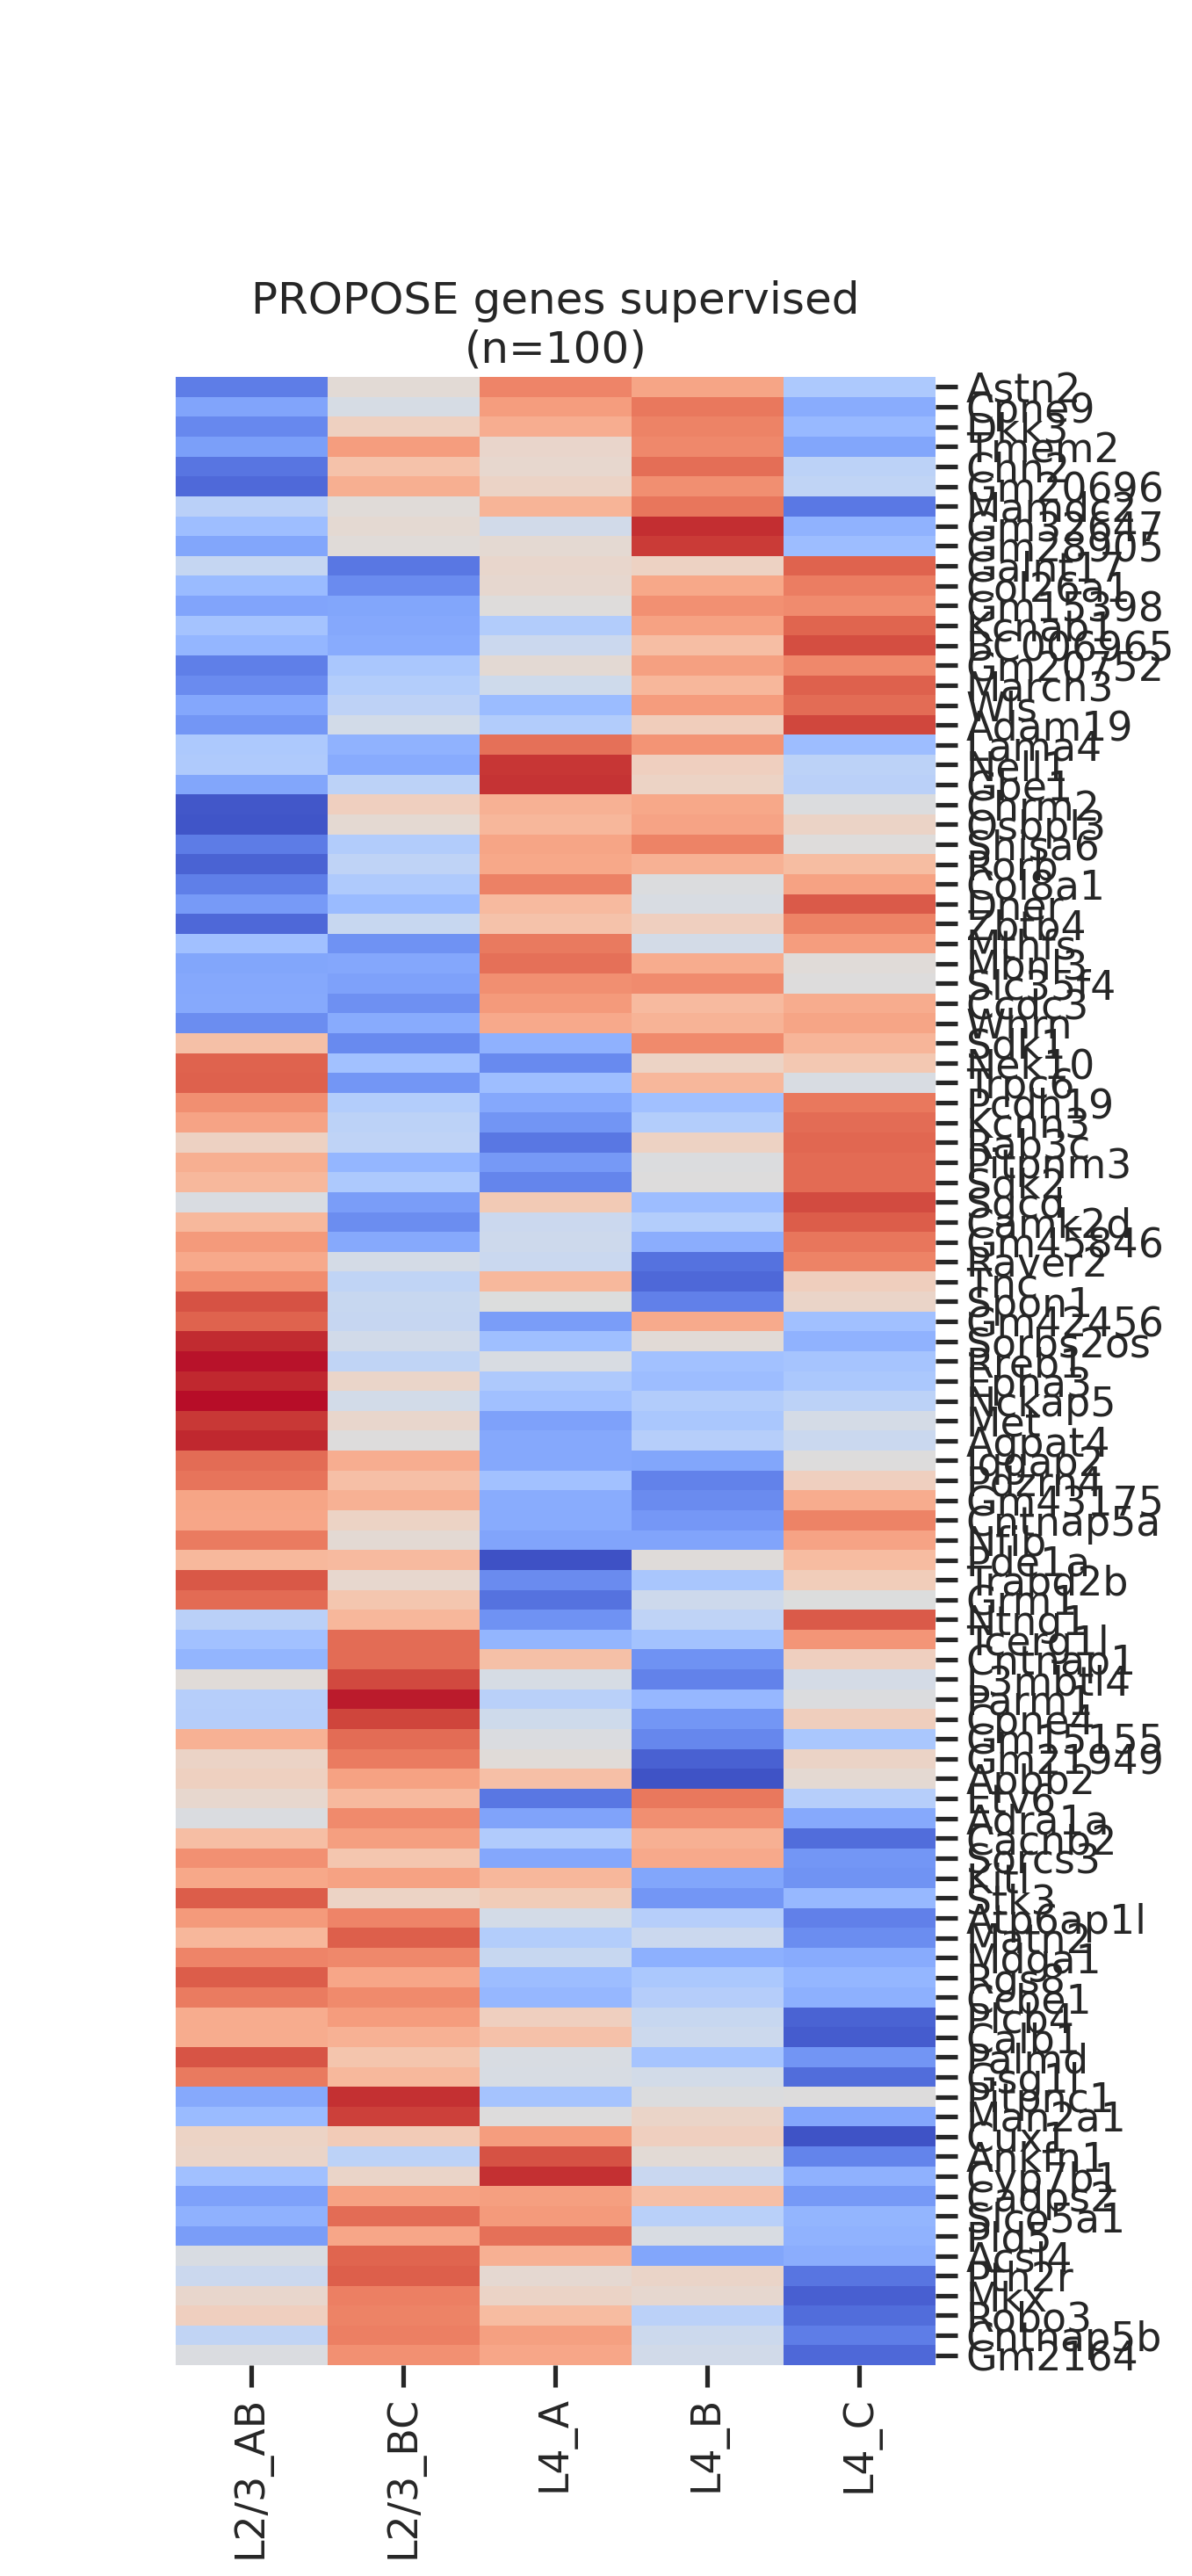

In [18]:
for key in res.keys():
    plot_num(Xk, key, cbar=False)

In [19]:
for num in res.keys(): 
    X_s = Xk[gene_names[res[num]]].T
    X_s.to_csv(f"../results/propose_{num}genes_P14_L234_supervised_Oct28.csv")